In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.tseries.offsets import DateOffset

In [45]:
df = pd.read_csv('AirPassengers.csv', index_col=0) # загружаем данные
df.index = pd.to_datetime(df.index)
print(df.shape)

(144, 1)


In [46]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<AxesSubplot:xlabel='Month'>

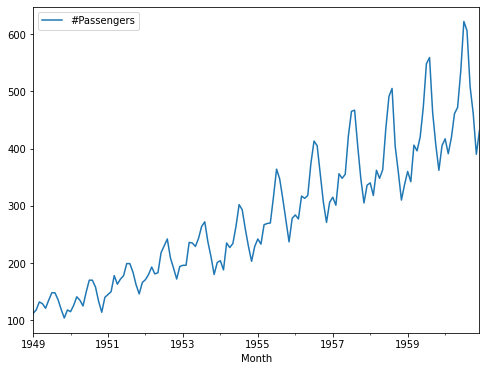

In [47]:
df.plot(figsize=(8,6))

In [48]:
def adfuller_test(series):
    """Тест на стационарность"""
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(adfuller(series),labels):
            print(label+' : '+str(value) )
            
adfuller_test(df['#Passengers'])

ADF Test Statistic : 0.8153688792060472
p-value : 0.991880243437641
#Lags Used : 13
Number of Observations : 130


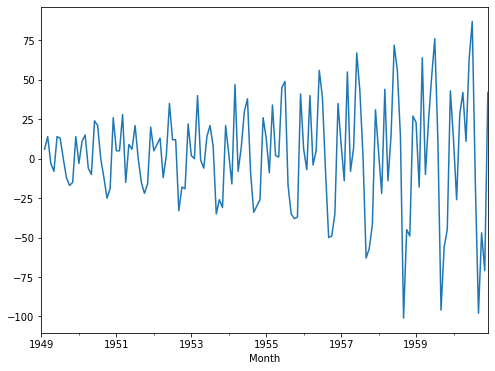

In [49]:
df['1difference'] = df['#Passengers']-df['#Passengers'].shift(1) # дифференцирование
df['1difference'].plot(figsize=(8,6));

In [50]:
# проверим продифферинцированный ряд на стационарность
adfuller_test(df['1difference'].dropna())

ADF Test Statistic : -2.8292668241700056
p-value : 0.054213290283824704
#Lags Used : 12
Number of Observations : 130


<AxesSubplot:xlabel='Month'>

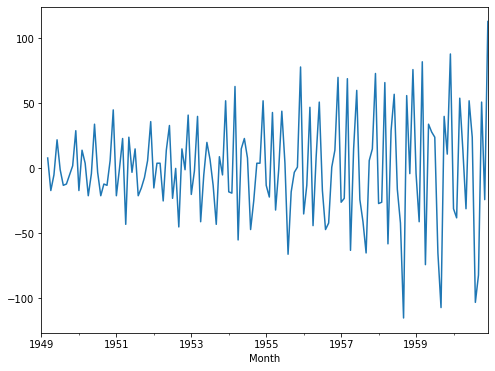

In [51]:
df['2difference']=df['1difference']-df['1difference'].shift(1) #дифференцирование
df['2difference'].plot(figsize=(8,6))

In [52]:
# проверим дважды продифферинцированный ряд на стационарность
adfuller_test(df['2difference'].dropna())

ADF Test Statistic : -16.384231542468495
p-value : 2.7328918500143186e-29
#Lags Used : 11
Number of Observations : 130


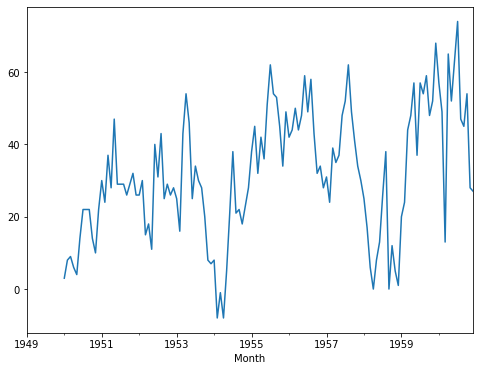

In [53]:
df['Seasonal_Difference']=df['#Passengers']-df['#Passengers'].shift(12) # сезонное дифференцирование
ax=df['Seasonal_Difference'].plot(figsize=(8,6))

In [54]:
# проверим сезонно продифферинцированный ряд на стационарность
adfuller_test(df['Seasonal_Difference'].dropna())

ADF Test Statistic : -3.383020726492481
p-value : 0.011551493085514952
#Lags Used : 1
Number of Observations : 130


/usr/local/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


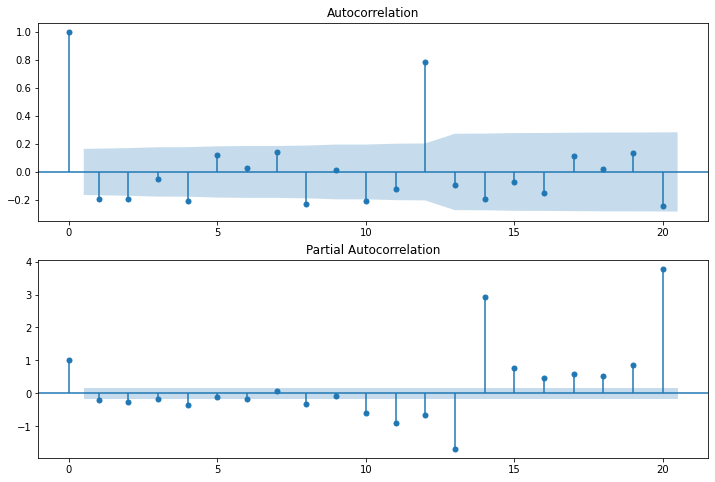

In [55]:
fig = plt.figure(figsize=(12,8)) # построим графики автокорреляций
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['2difference'].dropna(),lags=20,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['2difference'].dropna(),lags=20,ax=ax2)

In [60]:
model=SARIMAX(df['#Passengers'],order=(1,2,1),seasonal_order=(1, 0, 0, 12)) # создаем модель
result=model.fit()

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [61]:
new_dates=[df.index[-1]+DateOffset(months=x) for x in range(1,48)] # даты для предсказания
df_pred=pd.DataFrame(index=new_dates,columns =df.columns) # добавим в датасет

,#Passengers,1difference,2difference,Seasonal_Difference
1961-01-01,NaN,NaN,NaN,NaN
1961-02-01,NaN,NaN,NaN,NaN
1961-03-01,NaN,NaN,NaN,NaN
1961-04-01,NaN,NaN,NaN,NaN
1961-05-01,NaN,NaN,NaN,NaN


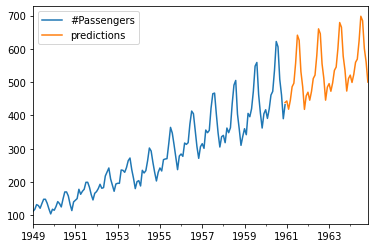

In [62]:
df2=pd.concat([df,df_pred])
df2['predictions']=result.predict(start=143,end=191) # делаем предсказание
df2[['#Passengers','predictions']].plot();